# Моделирование процесса закачки воды с кислотой в нефтенасыщенный пласт

## Теория

### МСС

#### Уравнения неразрывности

$$
\frac{\partial \rho_A}{\partial t} + \nabla \cdot (\rho_A \vec{v}_A) = J_{BA}
$$

Упрощенный случай

$$
\begin{gathered}
\alpha\, \text{CaCO}_3 + \beta\, \text{HCl} \approx (\alpha+\beta)\, \text{H}_2\text{O} 
\end{gathered}
$$

В одномерном случае с учетом несжимаемости получим

- для породы:
$$
- \frac{\partial \phi}{\partial t} = - \alpha J
$$

- для кислоты и воды:
$$
\begin{gathered}
\frac{\partial \phi S c}{\partial t} + W \frac{\partial b c}{\partial x} = - \beta J
\\
\frac{\partial \phi S (1 - c)}{\partial t} + W \frac{\partial b(1 - c)}{\partial x} = (\alpha+\beta) J
\end{gathered}
$$

- для нефти:
$$
\frac{\partial \phi (1 - S)}{\partial t} - W \frac{\partial b}{\partial x} = 0
$$

Складывая уравнения для воды и кислоты, получим:
$$
\frac{\partial \phi S}{\partial t} + W \frac{\partial b}{\partial x} = \alpha J
$$

Итого имеем 4 неизвестных: $\phi, S, c, J$ 
\
и 4 параметра реакции $\alpha, \beta, K, m$
\
и 4 уравнения:

$$
\begin{gathered}
\frac{\partial \phi}{\partial t} = \alpha J
\\
\frac{\partial \phi S}{\partial t} + W \frac{\partial b}{\partial x} = \alpha J 
\\
\frac{\partial \phi S c}{\partial t} + W \frac{\partial b c}{\partial x} = -\beta J
\\
J = K S (1 - \phi) c^m
\end{gathered}
$$

### Дискретизация

Дискретизируем разностями против потока полученную систему:

$$
\begin{gathered}
\frac{\phi^{n+1}_{i} - \phi^{n}_{i}}{\tau} = \alpha J^{n}_{i}
\\
\frac{\phi^{n+1}_{i} S^{n+1}_{i} - \phi^{n}_{i} S^{n}_{i}}{\tau} + W \frac{b^{n}_{i} - b^{n}_{i-1}}{h} = \alpha J^{n}_{i}
\\
\frac{\phi^{n+1}_{i} S^{n+1}_{i} c^{n+1}_{i} - \phi^{n}_{i} S^{n}_{i} c^{n}_{i}}{\tau} + W \frac{b^{n}_{i} c^{n}_{i} - b^{n}_{i-1} c^{n}_{i-1}}{h} = -\beta J^{n}_{i}
\\
J^{n}_{i} = K S^{n}_{i} (1 - \phi^{n}_{i}) {c^{n}_{i}}^m
\end{gathered}
$$

Алгоритм расчета:

1. Расчет скорости реакции
$$
J^{n}_{i} = K S^{n}_{i} (1 - \phi^{n}_{i}) {c^{n}_{i}}^m
$$
2. Расчет пористости
$$
\phi^{n+1}_{i} = \phi^{n}_{i} + \alpha J^{n}_{i} \tau
$$
3. Расчет насыщенности
$$
S^{n+1}_{i} = \frac{1}{\phi^{n+1}_{i}} \left[ \phi^{n}_{i} S^{n}_{i} + \tau \left( \alpha J^{n}_{i} - \frac{W}{h} (b^{n}_{i} - b^{n}_{i-1}) \right) \right] 
$$
4. Расчет концентрации
$$
c^{n+1}_{i} = \frac{1}{\phi^{n+1}_{i} S^{n+1}_{i}} \left[ \phi^{n}_{i} S^{n}_{i} c^{n}_{i} - \tau \left( \beta J^{n}_{i} + \frac{W}{h} (c^{n}_{i} b^{n}_{i} - c^{n}_{i-1} b^{n}_{i-1}) \right) \right] 
$$

## Реализация

### Импорт библиотек

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numba
from src.BuckleyLeverett import *

### Входные параметры

In [2]:
EPS = 0.95 # параметр схемной вязкости [0, 1), чем больше - тем сильнее размываются разрывы
# чем меньше - тем сильнее проявляются нефизичные осцилляции

In [3]:
# Геометрия
width = 1
height = 1
length = 100

# Хар-ки породы
initial_permeability = 1 * 10**(-12)
initial_porosity = 0.2

# Хар-ки флюидов
viscosity1 = 1 * 10**(-3)
viscosity2 = 4 * 10**(-3)

# Расход
flow = 10 * 10**(-3)

# Насыщенность
saturation_left = 1 - S_ORW
saturation_initial = S_WIR
conc_left = 0.3

# Параметры реакции
alpha = 2
beta = 1
K = 0.01
m = 2

# Кол-во узлов сетки
num_of_grid_points = 1000

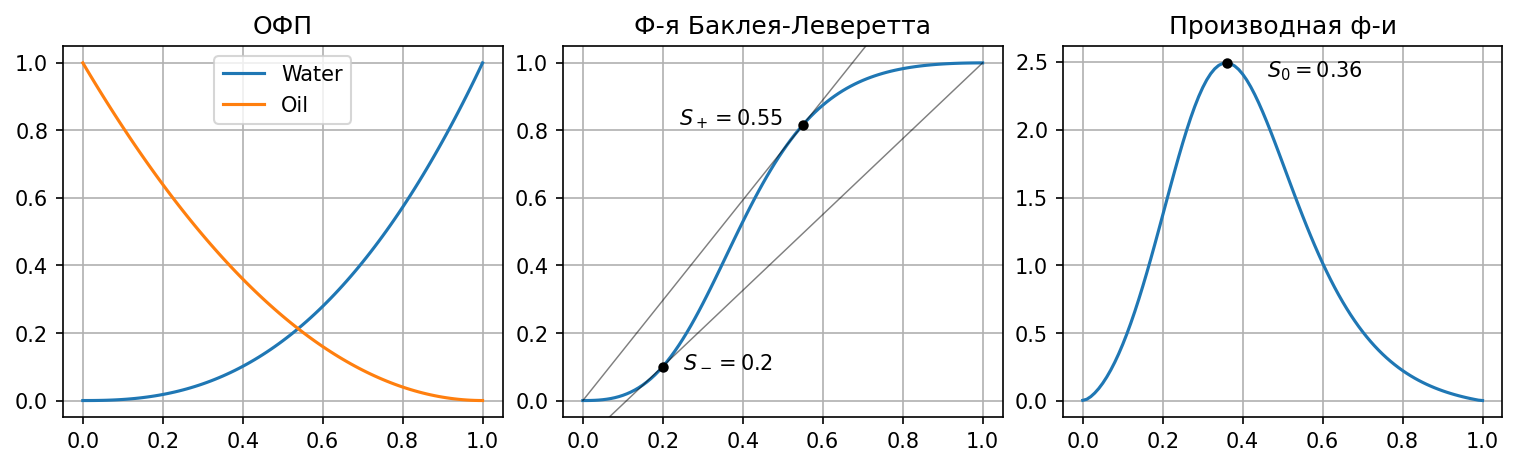

In [4]:
s_right = plot_buckley_leverett(viscosity1, viscosity2, return_Sfront=True, return_dfs=True)

### Инициализация

In [5]:
velocity = flow / (height * width)

x, h = np.linspace(0, length, num_of_grid_points, endpoint=True, retstep=True)

# Время расчета
total_time = length * s_right / b(s_right, viscosity1, viscosity2) / velocity * initial_porosity * 0.9
tau = initial_porosity * h / (2 * velocity) * (1 - EPS)
t = np.arange(0, total_time + tau, tau)
num_of_time_points = t.shape[0]

phi = np.zeros([num_of_time_points, num_of_grid_points])
phi[0, :] = initial_porosity

J = np.zeros([num_of_time_points, num_of_grid_points])

# W = np.zeros([num_of_time_points, num_of_grid_points])
S = np.zeros([num_of_time_points, num_of_grid_points])
S[0, :] = saturation_initial
S[:, 0] = saturation_left

conc = np.zeros([num_of_time_points, num_of_grid_points])

# boundary condition
    #   sin concentration
# conc[:, 0] = conc_left + 0.2 * np.sin(t/10)

    #   hairbrush concentration
n_intervals = 10
for i in range(n_intervals):
    if i % 2 == 0:
        conc[len(t)//10*i : len(t)//10*(i+1), 0] = conc_left
    else:
        conc[len(t)//10*i : len(t)//10*(i+1), 0] = 0

    #   const concentration
# conc[:, 0] = conc_left


### Вычисления

In [6]:
@numba.njit()
def calculate(num_of_time_points, num_of_grid_points, J, K, S, phi, conc, m, tau, viscosity1, viscosity2, velocity, h):
    for n in np.arange(0, num_of_time_points-1):
        J[n,:] = K * S[n,:] * (1 - phi[n,:]) * np.power(conc[n,:], m)
        phi[n+1,:] = phi[n,:] + alpha * J[n,:] * tau
        for i in np.arange(1, num_of_grid_points):
            b0 = b(S[n,i], viscosity1, viscosity2)
            b_ = b(S[n,i-1], viscosity1, viscosity2)

            S[n+1,i] = (phi[n,i] * S[n,i] + tau * (alpha * J[n,i] - velocity / h * (b0 - b_))) / phi[n+1,i]
            
            Sc = (phi[n,i] * S[n,i] * conc[n,i] - tau * (beta * J[n,i] + velocity / h * (conc[n,i] * b0 - conc[n,i-1] * b_))) / phi[n+1,i]

            if S[n+1, i] != 0:
                conc[n+1,i] = Sc / S[n+1, i]

In [7]:
calculate(num_of_time_points, num_of_grid_points, J, K, S, phi, conc, m, tau, viscosity1, viscosity2, velocity, h)

### Визуализация

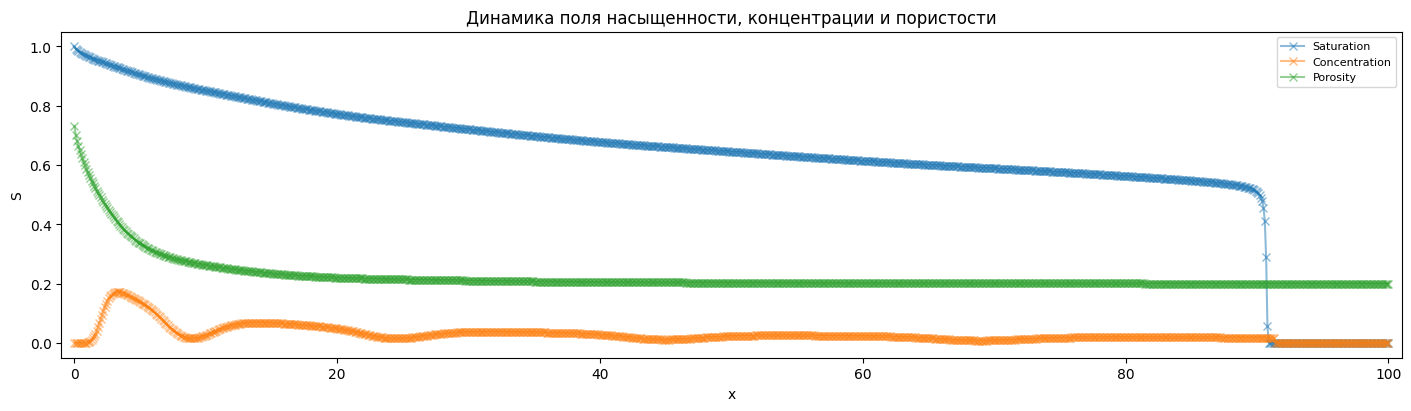

In [8]:
show = -1

fig, ax = plt.subplots(figsize=(14, 4), layout='constrained', dpi=100)

ax.plot(x, S[show], label="Saturation", marker="x", alpha=0.5)
# ax.plot(x, S2[show], label="Sat upwind scheme 2nd order", marker="x", alpha=0.5)

ax.plot(x, conc[show], label="Concentration", marker="x", alpha=0.5)
# ax.plot(xx[show], s, label="exact solution", linewidth=0.5, c="black")

ax.plot(x, phi[show], label="Porosity", marker="x", alpha=0.5)

plt.title("Динамика поля насыщенности, концентрации и пористости")

ax.set_ylabel("S")
ax.set_xlabel("x")
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.01 * length, length * 1.01])
# ax.set_xlim([9.7, 10.2])
plt.legend(fontsize=8)
plt.show()

### Анимация

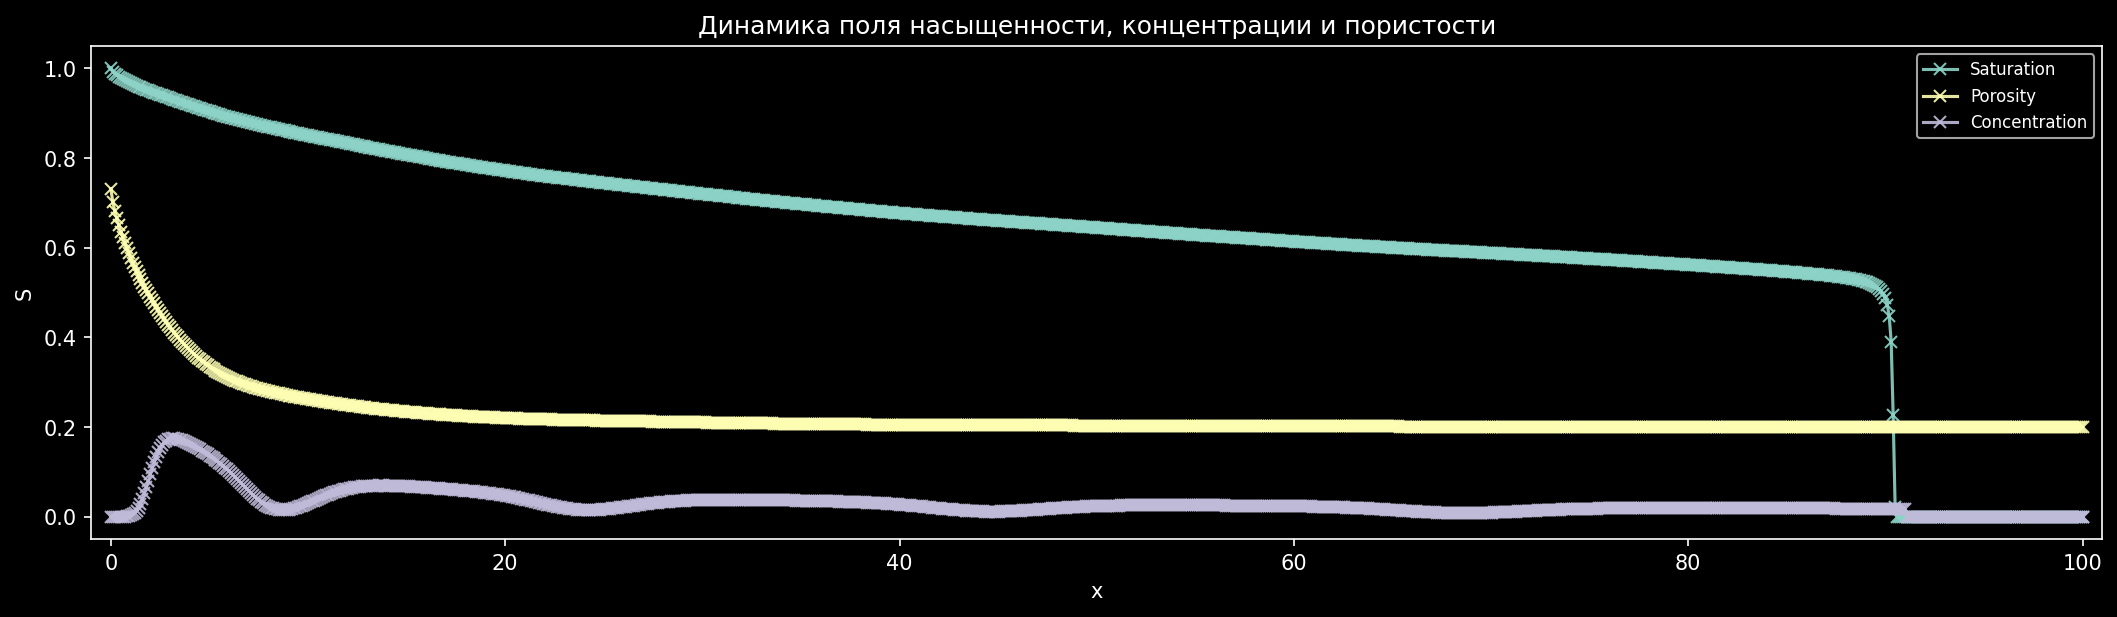

In [9]:
import matplotlib.animation as animation
plt.style.use('dark_background')

n_frames = 100

t_opt = []
conc_opt = []
sat_opt = []
phi_opt = []
for i in range(S.shape[0]):
    if i % (total_time // tau // (n_frames-1)) == 0:
        t_opt.append(t[i])
        conc_opt.append(conc[i])
        sat_opt.append(S[i])
        phi_opt.append(phi[i])


fig, ax = plt.subplots(figsize=(14, 4), layout='constrained', dpi=150)

# ax.plot(x, S[show], label="Sat upwind scheme", marker="x", alpha=0.5)
sat_line, = ax.plot(x, S[0], label="Saturation", marker="x", alpha=0.9)
phi_line, = ax.plot(x, phi[0], label="Porosity", marker="x", alpha=0.9)
conc_line, = ax.plot(x, conc[0], label="Concentration", marker="x", alpha=0.9)

plt.title("Динамика поля насыщенности, концентрации и пористости")

ax.set_ylabel("S")
ax.set_xlabel("x")
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.01 * length, length * 1.01])

ax.legend(fontsize=8)

def update(frame):
    # update the line plot:
    conc_line.set_data(x, conc_opt[frame])
    sat_line.set_data(x, sat_opt[frame])
    phi_line.set_data(x, phi_opt[frame])
    return conc_line, sat_line, phi_line

ani = animation.FuncAnimation(fig=fig, func=update, frames=n_frames, interval=0.1, blit=True)
ani.save(filename="../data/acid_field.gif", writer="pillow")